#Que.2

In [ ]:
import numpy as np
from timeit import default_timer as timer

In [ ]:
def evalf(n,x):  
  assert type(x) is np.ndarray and len(x) == n 
  function_value = 0
  for i in range(n-1):
    function_value = function_value + (x[i] -1)**2 + ( x[0] - (x[i])**2 )**2  
  return function_value 

In [ ]:
def evalg(n,x):  
  assert type(x) is np.ndarray and len(x) == n 
  gradient =[2*(x[0]-1) + 2*(x[0] - x[0]**2)*(1-2*x[0])]
  if n>=2:
   for i in range(1,n):
     gradient[0] = gradient[0] + 2*(x[0] - x[i]**2)
  for j in range(1,n):
     gradient.append(2*(x[j] -1) - 4*x[j]*(x[0] - x[j]**2)) 
  gradient = np.array(gradient)   
  return gradient

In [ ]:
def compute_steplength_backtracking(n, x, gradf, direction, alpha_start, rho, gamma):
  assert type(x) is np.ndarray and len(x) == n 
  assert type(gradf) is np.ndarray and len(gradf) == n  
  assert type(direction) is np.ndarray and len(gradf) == n
  assert type(alpha_start) is float and alpha_start>=0. 
  assert type(rho) is float and rho>=0.
  assert type(gamma) is float and gamma>=0. 
  
  alpha = alpha_start
  while  evalf(n , x+alpha*direction)> evalf(n,x) + gamma*alpha*np.matmul(gradf.T,direction):
    alpha=rho*alpha

  return alpha

In [ ]:
EXACT_LINE_SEARCH = 1
BACKTRACKING_LINE_SEARCH = 2
CONSTANT_STEP_LENGTH = 3

In [ ]:
def find_minimizer_BFGS(n,start_x, tol, line_search_type, *args):
  assert type(start_x) is np.ndarray  and len(start_x) == n 
  assert type(tol) is float and tol>=0 

  x = start_x
  g_x = evalg(n,x).reshape((n,1)) 
  B_k = np.identity(n)/5
  

  if(line_search_type == BACKTRACKING_LINE_SEARCH):
    alpha_start = args[0]
    rho = args[1]
    gamma = args[2]

  k=0
  while (np.linalg.norm(g_x) > tol):
    p_k = - np.matmul(B_k, g_x)
    step_length = compute_steplength_backtracking(n, x, g_x, p_k, alpha_start, rho, gamma)
    
    x_0 = x
    x = x + np.multiply(step_length,p_k)
    s_k = x - x_0
    y_k = evalg(n , x) - evalg(n , x_0)
    u_k = (np.matmul(y_k.T,s_k))**(-1)

    first_term  = np.identity(n) - u_k*np.matmul(s_k,y_k.T)
    sec_term = np.identity(n) - u_k*np.matmul(y_k, s_k.T)
    B_k = np.matmul(np.matmul(first_term ,B_k),sec_term) + u_k*np.matmul(s_k,s_k.T)  

    k += 1 
    g_x = evalg(n, x) 

  return x,k, evalf(n, x)

#3. [R] Take n ∈ {1000, 2500, 5000, 7500, 10000}, find minimizer of the objective function in each case and compute the time taken by the BFGS method with backtracking line search. Tabulate the time taken by BFGS method for each n

#Solution:

In [ ]:
n_value = [1000,2500,5000,7500,10000]
my_tol = 10**(-3)
time_taken = []
obj = []
x = []
iteration_list = []

for n in n_value:
  start_x = np.array([0 for i in range(n)]).reshape((n,1))
  time1 = timer()
  x_min ,k,fun  = find_minimizer_BFGS(n, start_x, my_tol, BACKTRACKING_LINE_SEARCH, 0.9, 0.5 ,0.5 )
  time2 = timer()
  iteration_list.append(k)
  x.append(x_min)
  obj.append(fun)
  time = time2 - time1
  time_taken.append(time)

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame()
df['n_value'] = n_value
df['time_takken']=time_taken
df['otimal_value']=obj
df['minimizer']=x
df['number_of_iterations']=iteration_list

In [ ]:
df

n_value  time_takken              otimal_value  \
0     1000     6.735493  [1.1561865119435349e-10]   
1     2500    53.263776  [4.6087315841461725e-11]   
2     5000    84.713850   [9.408375327514363e-11]   
3     7500   208.026458  [3.3801512139641835e-11]   
4    10000   630.212642  [1.8996014659022958e-12]   

                                           minimizer  number_of_iterations  
0  [[0.9999993932576948], [0.9999998483913153], [...                    11  
1  [[0.9999997024623237], [0.9999998925871826], [...                    11  
2  [[0.9999996992484416], [0.9999998915130355], [...                    11  
3  [[0.9999998520336952], [0.99999994578142], [0....                    10  
4  [[0.9999999698901554], [0.9999999892590907], [...                    12

In [ ]:
def evalh(x,n):
  assert type(x) is np.ndarray and len(x) == n 
  hessian_matrix = np.zeros((n,n))
  hessian_matrix[0][0] = 2 -4*(x[0] - x[0]**2) + 2*(1- 2*x[0])**2
  if n>=2:
    for i in range(1,n):
      hessian_matrix[0][0] = hessian_matrix[0][0] + 2
      hessian_matrix[0][i] = -4*x[i]
  
  for i in range(1,n):
    hessian_matrix[i][i] = 2 - 4*(x[0] - x[i]**2) + 8*(x[i]**2)
    hessian_matrix[i][0] = hessian_matrix[0][i] 

  return hessian_matrix

In [ ]:
def find_minimizer_newton(n, start_x, tol,line_search_type, *args):
  assert type(start_x) is np.ndarray and len(start_x)  == n
  assert type(tol) is float and tol>=0 

  x = start_x
  g_x = evalg(n,x ).reshape((n,1))
  if(line_search_type == BACKTRACKING_LINE_SEARCH):
    alpha_start = args[0]
    rho = args[1]
    gamma = args[2]

  k=0
  while (np.linalg.norm(g_x) > tol):
    D_k = np.linalg.inv(evalh(x,n))
    p_k = -np.matmul(D_k, g_x)
    step_length = compute_steplength_backtracking(n,x, g_x, p_k, alpha_start, rho, gamma)
  
    x = np.add(x,np.multiply(step_length,p_k))
    k += 1 
    g_x = evalg(n,x)
  return x, k, evalf(n,x )

#5. [R] Take n ∈ {1000, 2500, 5000, 7500, 10000}, find minimizer of the objective function in each case and compute the time taken by the Newton’s method with backtracking line search. Tabulate the time taken by Newton’s method for each n. 

#Solution:

In [ ]:
n_value = [1000,2500,5000,7500,10000]
my_tol = 10**(-3)
time_taken_newton = []
obj_newton = []
x_newton = []
iteration_number = []

for n in n_value:
  start_x = np.array([0 for i in range(n)]).reshape((n,1))
  time1_n = timer()
  x_min_n ,k_n,fun_n  = find_minimizer_newton(n, start_x, my_tol, BACKTRACKING_LINE_SEARCH, 0.9, 0.5 ,0.5 )
  time2_n = timer()
  iteration_number.append(k_n)
  x_newton.append(x_min_n)
  obj_newton.append(fun_n)
  time = time2_n - time1_n
  time_taken_newton.append(time)

In [ ]:
df1 = pd.DataFrame()
df1['n_value'] = n_value
df1['time_takken']=time_taken_newton
df1['otimal_value']=obj_newton
df1['minimizer']=x_newton
df1['number_of_iterations']=iteration_number

In [ ]:
df1

n_value  time_takken              otimal_value  \
0     1000    14.946710  [1.4724404524213782e-11]   
1     2500    55.806893   [3.774150844618039e-11]   
2     5000   136.554498   [7.611555514925466e-11]   
3     7500   258.675678  [1.1449167053999634e-10]   
4    10000   289.537704  [1.5286868125241803e-12]   

                                           minimizer  number_of_iterations  
0  [[0.999999731235726], [0.9999998981917647], [0...                     9  
1  [[0.9999997271963473], [0.9999998966185254], [...                     9  
2  [[0.9999997258324934], [0.9999998960872618], [...                     9  
3  [[0.9999997253759194], [0.9999998959094036], [...                     9  
4  [[0.9999999725146919], [0.9999999895820205], [...                    10

#6. [R] Compare the time taken by BFGS method with backtracking line search against the time taken by Newton’s method with backtracking line search for each value of n. Plot the time taken by both methods vs n using different colors. Comment on your observations.

#Solution:

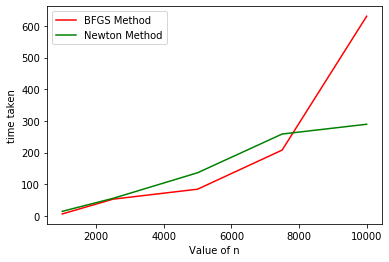

In [ ]:
import matplotlib.pyplot as plt
plt.plot(n_value,time_taken,"r")
plt.plot(n_value,time_taken_newton,"g")
plt.xlabel("Value of n")
plt.ylabel("time taken")
plt.legend(["BFGS Method","Newton Method"]);

#from the above graph BFGS is taking more time than newton method for large value of n. when increase the value of n the difference of time taken by BFGS method and Newton method increases.